[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/juansensio/blog/blob/master/105_cfd_fvm/105_cfd_fvm.ipynb)

# Volúmenes Finitos

En el post anterior hicimos una introducción a los diferentes métodos numéricos que tenemos a nuestra disposición a la hora de resolver ecuaciones diferenciales. De entre ellos, hicimos un primer ejemplo de volúmenes finitos. En este post vamos a entrar en detalle en éste método y ver qué efecto tienen los diferentes parámetros sobre la calidad de la solución en el ejemplo sencillo de la ecuación de convección  (pero que se trasladarán en su mayoría a casos más complicados).

$$
\phi_t + u \phi_x = 0
$$

y su solución analítica 

$$
\phi(x,t) = \phi_0(x - ut)
$$

## La Malla

Como ya vimos en el post anterior, el primer paso a la hora de resolver una ecuación de diferencial de manera numérica mediante volúmenes finitos es la discretización del dominio, o la generación de la malla. Ésta estará formada por:

- celdas: subdivsiones del dominio (que no se superponen) en las que resolveremos nuestra ecuación de manera local. La solución global se obtiene al juntar todas las soluciones locales, en una función discontinua a trozos.
- caras: conexiones entre celdas, son las superficies sobre las que calcularemos los flujos, la cantidad de magnitud conservativa que entra o sale de la celda a través de la cara.

En nuestro primer ejemplo sencillo podemos representar tanto celdas como caras mediante listas de puntos. Cuando pasemos a casos bidimensionales y tridimensionales la cosa se complicará un poco :)

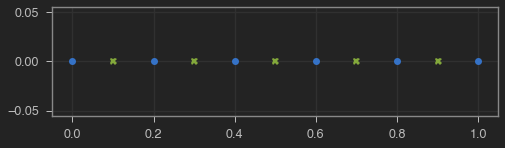

In [1]:
import numpy as np 
import matplotlib.pyplot as plt

def geom(N, x0=0, x1=1):
	f = np.linspace(x0, x1, N+1)
	c = np.array([0.5*(f[i] + f[i+1]) for i in range(N)])
	return f, c

f, c = geom(5)

plt.figure(figsize=(8, 2))
plt.plot(f, np.zeros(f.shape[0]), 'o')
plt.plot(c, np.zeros(c.shape[0]), 'X')
plt.grid(True)
plt.show()

En el ejemplo anterior hemos generado una malla con 10 celdas, o volúmenes finitos (lo que implica 11 caras). Cada celda está representada por la posición de su **centroide**, que en este caso es el punto equidistante a cada una de las caras (aunque este valor realmente no se usa para nada ya que lo que nos interesa realmente es el valor promedio en la celda, aunque lo representemos en su centroide). De la misma manera, cada cara está representada por la posición de su centroide también. La distancia entre caras es constante en toda la malla, lo que se conoce como malla **uniforme**. Si las caras estuviesen más juntas o separadas en diferentes partes del dominio, hablaríamos de malla **no uniforme** (lo cual veremos en posts futuros). Como puedes imaginar, cuántas más celdas tengamos más precisa será nuestra aproximación. Por otro lado, mayor será el coste computacional. Así pues, uno de los principales trabajos de cualquier ingeniero de simulaciones es el de generar mallas lo suficientemente buenas como para obtener una buena solución sin incurrir en grandes requisitos computacionales.

## La condición inicial

A la hora de resolver cualquier ecuación diferencial necesitamos conocer la condición inicial, situación a partir de la cual empezará nuestra simulación. En nuestro ejemplo, vamos a considerar dos condiciones iniciales que nos permitirán estudiar diferentes propiedades de los volúmenes finitos. En primer lugar, una condición inicial suave.

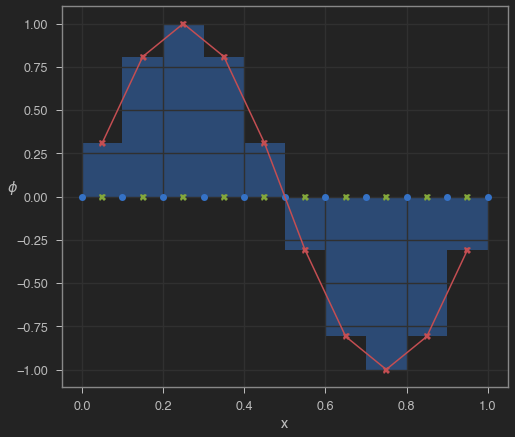

In [2]:
f, c = geom(10)

def smooth(x):
	return np.sin(2 * np.pi * x)

p0 = smooth(c)

plt.plot(f, np.zeros(f.shape[0]), 'o')
plt.plot(c, np.zeros(c.shape[0]), 'X')
plt.plot(c, p0, 'X-')
plt.bar(c, p0, width=0.1, alpha=0.5)
plt.xlabel('x')
plt.ylabel('$\phi$', rotation=0)
plt.grid(True)
plt.show()

Y en segundo lugar, una discontínua (de tipo sombrero)


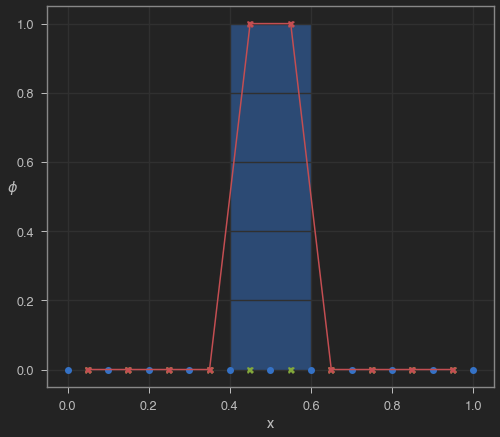

In [3]:
f, c = geom(10)

def hat(x, x0=0.4, x1=0.6):
	return np.where((x >= x0) & (x <= x1), 1, 0)

p0 = hat(c)

plt.plot(f, np.zeros(f.shape[0]), 'o')
plt.plot(c, np.zeros(c.shape[0]), 'X')
plt.plot(c, p0, 'X-')
plt.bar(c, p0, width=0.1, alpha=0.5)
plt.xlabel('x')
plt.ylabel('$\phi$', rotation=0)
plt.grid(True)
plt.ylim([-0.05, 1.05])
plt.show()

## Calculando Flujos

Como ya vimos en el post anterior, el siguiente paso a la hora de resolver nuestra ecuación de forma numérica es calcular los flujos en las caras. Sin embargo, al no tener valores claramente definidos, deberemos usar algún tipo de aproximación (la elección de la cual, lamentablemente, afectará de gran manera a la calidad de nuestra solución).

$$ 
\phi_t^k = \frac{u \phi(x^{k - 1/2}, t) - u \phi(x^{k + 1/2}, t)}{V^k}
$$


En primer lugar, podemos aprovechar las características físicas de nuestro problema (la solución inicial se mueve en la dirección de la velocidad) para calcular el flujo de manera consecuente. Este tipo de esquemas numéricos se conocen como esquemas de tipo **upwind**, y se basan en usar el valor de la variable aguas arriba.

$$
\phi(x^{k + 1/2}, t) = u^+ \phi(x^{k}, t) + u^- \phi(x^{k+1}, t)
$$

> $u^+$ será igual a $u$ siempre que $u > 0$, mientras que $u^-$ será igual a $u$ siempre que $u < 0$. Si $u = 0$, cualquier valor es válido.

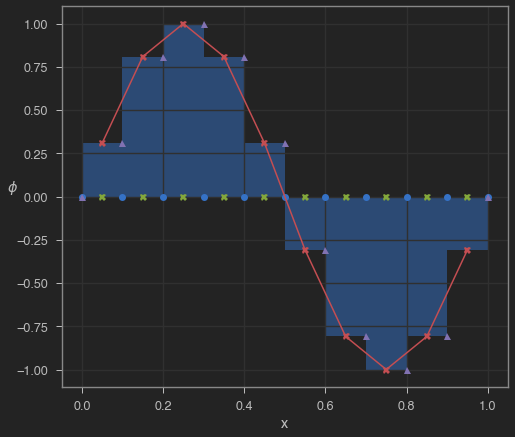

In [4]:
u = 1

def upwind(f, u, p):
	F = np.zeros(len(f))
	F[1:-1] = [u*(u > 0)*p[i] + u*(u < 0)*p[i+1] for i in range(len(f[1:-1]))]
	return F

p0 = smooth(c)
F = upwind(f, u, p0)

plt.plot(f, np.zeros(f.shape[0]), 'o')
plt.plot(c, np.zeros(c.shape[0]), 'X')
plt.plot(c, p0, 'X-')
plt.bar(c, p0, width=0.1, alpha=0.5)
plt.plot(f, F, '^')
plt.xlabel('x')
plt.ylabel('$\phi$', rotation=0)
plt.grid(True)
plt.show()

En el caso de la condición inicial suave, puedes ver que con una velocidad $u$ positiva el flujo en las caras usa el valor de $\phi$ de la izquierda, o aguas arriba. Con un valor negativo de $u$, usará el valor de la derecha (que sigue siendo aguas arriba, ya que ahora el flujo viene de esa dirección). 

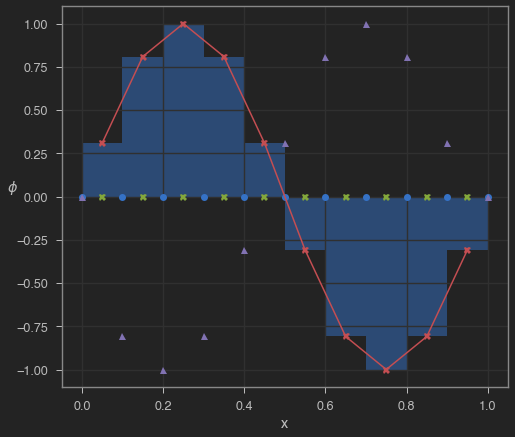

In [5]:
u = -1

p0 = smooth(c)
F = upwind(f, u, p0)

plt.plot(f, np.zeros(f.shape[0]), 'o')
plt.plot(c, np.zeros(c.shape[0]), 'X')
plt.plot(c, p0, 'X-')
plt.bar(c, p0, width=0.1, alpha=0.5)
plt.plot(f, F, '^')
plt.xlabel('x')
plt.ylabel('$\phi$', rotation=0)
plt.grid(True)
plt.show()

Una alternativa a este tipo de flujos son los esquemas de tipo **centrado**, que simplemente calculan el valor promedio. 

$$
\phi(x^{k + 1/2}, t) = \frac{u \phi(x^{k}, t) + u \phi(x^{k+1}, t)}{2}
$$


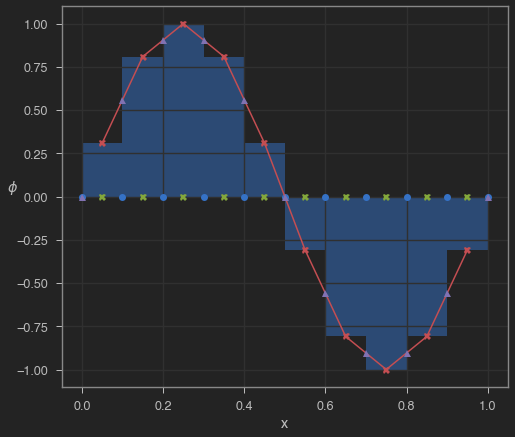

In [6]:
u = 1

def central(f, u, p):
	F = np.zeros(len(f))
	F[1:-1] = [u*0.5*(p[i] + p[i+1]) for i in range(len(f[1:-1]))]
	return F

p0 = smooth(c)
F = central(f, u, p0)

plt.plot(f, np.zeros(f.shape[0]), 'o')
plt.plot(c, np.zeros(c.shape[0]), 'X')
plt.plot(c, p0, 'X-')
plt.bar(c, p0, width=0.1, alpha=0.5)
plt.plot(f, F, '^')
plt.xlabel('x')
plt.ylabel('$\phi$', rotation=0)
plt.grid(True)
plt.show()

Existen tantos esquemas numéricos como científicos aburridos en el mundo, todos ellos intentando mejorar o resolver los problemas que el resto presentan, pero los podemos clasificar según el orden de su aproximación en esquemas de primero orden (o bajo orden) y esquemas de alto orden (segundo, tercero, ... en función de la cantidad de celdas que usemos a la hora de hacer la aproximación). En esta serie de posts solo veremos esquemas de bajo orden, mientras que exploraremos reconstrucción de alto orden cuando veamos los métodos de tipo Galerkin. 

## Condiciones de contorno

Además de la condición inicial, para resolver ecuaciones diferenciales debemos conocer las condiciones de contorno. En el caso de los volúmenes finitos podemos introducir estas condiciones a través de los flujos en las caras del contorno. En este ejemplo sencillo consideraremos condiciones de contorno periódicas, lo que significa que el dominio se pliega sobre si mismo y la entrada y la salida son lo mismo (por eso nuestra condición inicial se queda dando vueltas hasta el infinito). Más adelante veremos otras condiciones de contorno, como paredes, entradas y salidas, etc.

In [7]:
def periodic_upwind(F, u, p):
	F[0] = F[-1] = u*(u > 0)*p[-1] + u*(u < 0)*p[0]
	return F

def periodic_central(F, u, p):
	F[0] = F[-1] = u*0.5*(p[-1] + p[0])
	return F

## *Update* temporal

El último paso en el proceso de la simulación es el *update* temporal, o cómo calcular el valor de $\phi(x, t + \Delta t)$ a partir de $\phi(x, t)$ y los flujos. Para ello se suelen usar esquemas de integración temporal, los cuales pueden ser también de bajo o alto orden, a la vez que explícitos o implícitos. En estos posts nos restringiremos a esquemas de tipo explícitos, de los cuales veremos ejemplos de bajo orden como el esquema de integración de Euler

$$
\phi_{n+1} = \phi_n + \Delta t R_n
$$ 

y esquemas de alto orden como el método de Adam-Bashforth (orden 2)

$$
\phi_{n+2} = \phi_{n+1} + \frac{3}{2} \Delta t R_{n+1} - \frac{1}{2} \Delta t R_{n}
$$ 

o Runge Kutta, donde $R^k_{n} = (F_n^{k - 1/2} - F_n^{k + 1/2}) / V^k$.

In [36]:
def euler(F, f, c, p, dt):
	R = np.array([(F[i] - F[i+1])/(f[i+1] - f[i]) for i in range(len(c))])
	return p + dt*R

def ab2(F, f, c, p, dt, R0):
	R = np.array([(F[i] - F[i+1])/(f[i+1] - f[i]) for i in range(len(c))])
	return p + 0.5*dt*(3.*R - R0), R

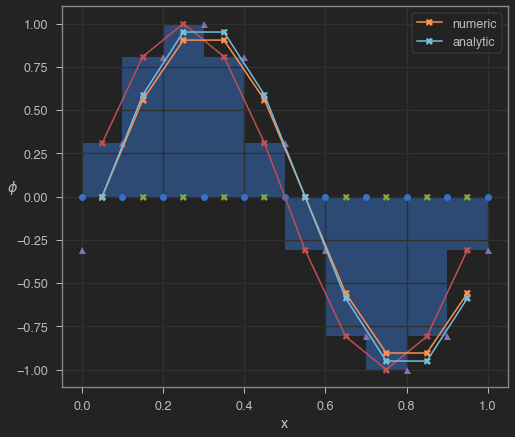

In [37]:
u, dt = 1, 0.05
f, c = geom(10)

p0 = smooth(c)
F = upwind(f, u, p0)
F = periodic_upwind(F, u, p0)
p1 = euler(F, f, c, p0, dt)

plt.plot(f, np.zeros(f.shape[0]), 'o')
plt.plot(c, np.zeros(c.shape[0]), 'X')
plt.plot(c, p0, 'X-')
plt.bar(c, p0, width=0.1, alpha=0.5)
plt.plot(f, F, '^')
plt.plot(c, p1, 'X-', label='numeric')
p1a = np.sin(2 * np.pi * (c - u*dt ))
plt.plot(c, p1a, 'X-', label='analytic')
plt.xlabel('x')
plt.ylabel('$\phi$', rotation=0)
plt.grid(True)
plt.legend()
plt.show()

En este caso el salto temporal, $\Delta t$, lo estamos fijando nosotros. Su elección tendrá influencia sobre el resultado, como veremos a continuación, donde introduciremos un método para encontrar su valor óptimo.

## Comparación

Una vez introducidos los conceptos básicos vamos a comparar diferentes combinaciones de parámetros y extraer conclusiones. En todos los experimentos vamos a ejecutar una simulación durante tiempo determinado y a comparar con la solución analítica. Primero haremos un ejemplo usando el esquema de tipo upwind con el esquema de integración temporal euler.

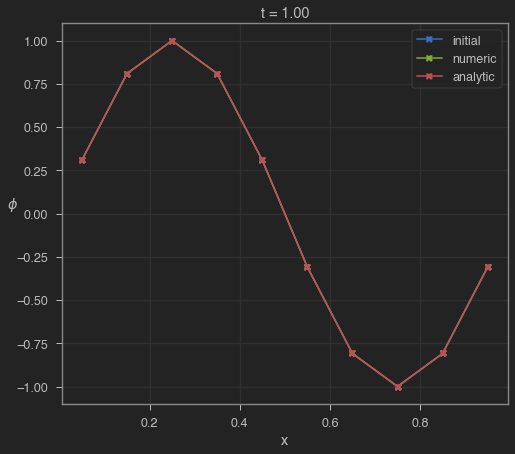

In [38]:
# parmámetros
f, c = geom(10)
u, dt, t, tf = 1, 0.1, 0, 1

# condiciones iniciales
p0 = smooth(c)
p = p0.copy()

while t < tf:
	
	# update temporal
	if t + dt > tf:
		dt = tf - t
	t = t + dt
	# print(f't = {t:.2f}, dt = {dt:.2f}')

	F = upwind(f, u, p)
	F = periodic_upwind(F, u, p)
	p = euler(F, f, c, p, dt)

plt.plot(c, p0, 'X-', label='initial')
plt.plot(c, p, 'X-', label='numeric')
pa = np.sin(2 * np.pi * (c - u*t ))
plt.plot(c, pa, 'X-', label='analytic')
plt.xlabel('x')
plt.ylabel('$\phi$', rotation=0)
plt.title(f't = {t:.2f}')
plt.grid(True)
plt.legend()
plt.show()

Para las condiciones concretas de este ejemplo podemos observar algo muy curioso, y es que nuestra solución numérica SIEMPRE coincide con la analítica. ¿Significa esto que usando el esquema upwind con integración de tipo euler es la mejor combinación? La respuesta es NO. Si cambiamos el número de celdas, la velocidad del fluid o el salto temporal obtendremos errores.

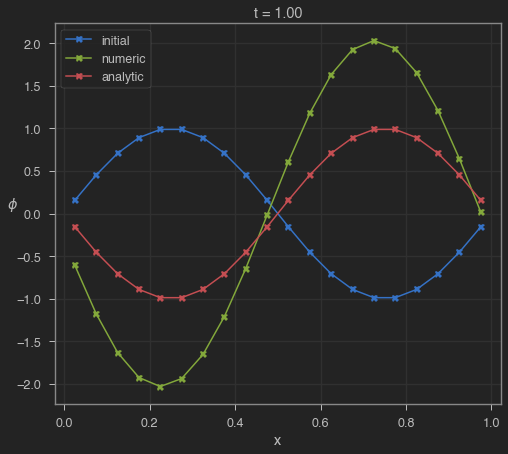

In [39]:
# parmámetros
f, c = geom(20)
u, dt, t, tf = 1.5, 0.05, 0, 1

# condiciones iniciales
p0 = smooth(c)
p = p0.copy()

while t < tf:
	
	# update temporal
	if t + dt > tf:
		dt = tf - t
	t = t + dt
	# print(f't = {t:.2f}, dt = {dt:.2f}')

	F = upwind(f, u, p)
	F = periodic_upwind(F, u, p)
	p = euler(F, f, c, p, dt)

plt.plot(c, p0, 'X-', label='initial')
plt.plot(c, p, 'X-', label='numeric')
pa = np.sin(2 * np.pi * (c - u*t ))
plt.plot(c, pa, 'X-', label='analytic')
plt.xlabel('x')
plt.ylabel('$\phi$', rotation=0)
plt.title(f't = {t:.2f}')
plt.grid(True)
plt.legend()
plt.show()

Existe una combinación mágica que nos permitirá recuperar nuestra solución perfecta, y ésta es usar $\Delta t = \frac{\Delta x}{u}$.

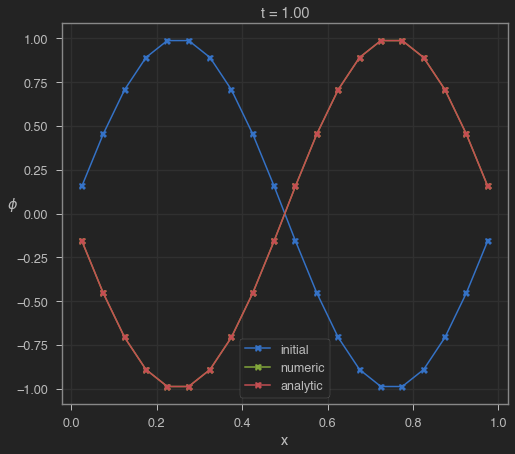

In [40]:
# parmámetros
f, c = geom(20)
u, t, tf = 1.5, 0, 1
dt = (f[1] - f[0])/u # CFL

# condiciones iniciales
p0 = smooth(c)
p = p0.copy()

while t < tf:
	
	# update temporal
	if t + dt > tf:
		dt = tf - t
	t = t + dt
	# print(f't = {t:.2f}, dt = {dt:.2f}')

	F = upwind(f, u, p)
	F = periodic_upwind(F, u, p)
	p = euler(F, f, c, p, dt)

plt.plot(c, p0, 'X-', label='initial')
plt.plot(c, p, 'X-', label='numeric')
pa = np.sin(2 * np.pi * (c - u*t ))
plt.plot(c, pa, 'X-', label='analytic')
plt.xlabel('x')
plt.ylabel('$\phi$', rotation=0)
plt.title(f't = {t:.2f}')
plt.grid(True)
plt.legend()
plt.show()

El siguiente desarrollo nos permitirá entender qué pasa aquí:

$$
	\phi^k_{n+1} = \phi^k_n - \Delta t R^k_n = \phi^k_n - \frac{\Delta t}{V^k}  (F_n^{k - 1/2} - F_n^{k + 1/2})
$$ 

Asumiendo $u > 0$

$$
	\phi^k_{n+1} = \phi^k_n - \frac{u \Delta t}{V^k}  (\phi_n^{k - 1} - \phi_n^{k})
$$ 

Y si $\Delta t = \frac{\Delta x}{u}$ entonces

$$
	\phi^k_{n+1} = \phi_n^{k - 1} 
$$ 

Lo cual corresponde exactamente con la solución analítica. En cualquier otro caso, sin embargo, esto no se cumplirá y la solución aproximada tendrá errores. Esto se debe a que la elección de $\Delta t$ es tal que toda la información de una celda se transfiere a su vecina sin pérdida. Un valor mayor provocaría que la información viajase demasiado, saltándose a la celda vecina, mientras que un valor menor no transfiere la cantidad exacta (lo cual resulta en errores numéricos). Este valor, conocido como *CFL*, se usa como criterio a la hora de escoger un valor de $\Delta t$ (aunque a la práctica suele usarse uno menor) y nos asegura que la información no viajará más de lo debido. En posts futuros hablaremos en más detalle sobre este concepto.

Al usar un esquema upwind, el resultado más normal es el siguiente

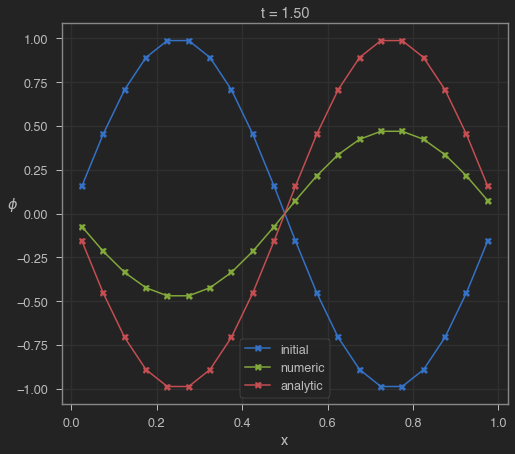

In [50]:
# parmámetros
f, c = geom(20)
u, t, tf = 1, 0, 1.5
dt = 0.5*(f[1] - f[0])/u # CFL

# condiciones iniciales
p0 = smooth(c)
p = p0.copy()
R = np.zeros_like(p)

while t < tf:
	
	# update temporal
	if t + dt > tf:
		dt = tf - t
	t = t + dt
	# print(f't = {t:.2f}, dt = {dt:.2f}')

	F = upwind(f, u, p)
	F = periodic_upwind(F, u, p)
	p = euler(F, f, c, p, dt)
	# p, R = ab2(F, f, c, p, dt, R)


plt.plot(c, p0, 'X-', label='initial')
plt.plot(c, p, 'X-', label='numeric')
pa = np.sin(2 * np.pi * (c - u*t ))
plt.plot(c, pa, 'X-', label='analytic')
plt.xlabel('x')
plt.ylabel('$\phi$', rotation=0)
plt.title(f't = {t:.2f}')
plt.grid(True)
plt.legend()
plt.show()

Como puedes observar la solución numérica sufre de *difusión numérica*. Nuestra condición inicial debería trasladarse por el dominio sin cambiar, sin embargo se está achatando (otro término para difundiendo). Esta es una característica típica de los esquema de tipo upwind, y la solución es usar mejor resolución espacial (lo cual implica mayor coste computacional).

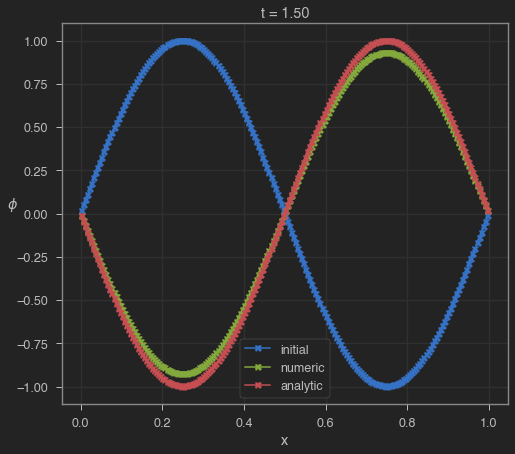

In [52]:
# parmámetros
f, c = geom(200)
u, t, tf = 1, 0, 1.5
dt = 0.5*(f[1] - f[0])/u # CFL

# condiciones iniciales
p0 = smooth(c)
p = p0.copy()
R = np.zeros_like(p)

while t < tf:
	
	# update temporal
	if t + dt > tf:
		dt = tf - t
	t = t + dt
	# print(f't = {t:.2f}, dt = {dt:.2f}')

	F = upwind(f, u, p)
	F = periodic_upwind(F, u, p)

	p = euler(F, f, c, p, dt)
	# p, R = ab2(F, f, c, p, dt, R)


plt.plot(c, p0, 'X-', label='initial')
plt.plot(c, p, 'X-', label='numeric')
pa = np.sin(2 * np.pi * (c - u*t ))
plt.plot(c, pa, 'X-', label='analytic')
plt.xlabel('x')
plt.ylabel('$\phi$', rotation=0)
plt.title(f't = {t:.2f}')
plt.grid(True)
plt.legend()
plt.show()

Vamos ahora a evaluar el esquema espacial de tipo centrado.

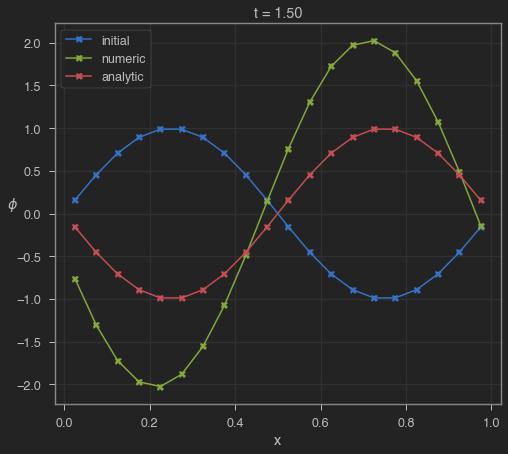

In [56]:
# parmámetros
f, c = geom(20)
u, t, tf = 1, 0, 1.5
dt = 0.5*(f[1] - f[0])/u # CFL

# condiciones iniciales
p0 = smooth(c)
p = p0.copy()
R = np.zeros_like(p)

while t < tf:
	
	# update temporal
	if t + dt > tf:
		dt = tf - t
	t = t + dt
	# print(f't = {t:.2f}, dt = {dt:.2f}')

	F = central(f, u, p)
	F = periodic_central(F, u, p)

	p = euler(F, f, c, p, dt)
	# p, R = ab2(F, f, c, p, dt, R)


plt.plot(c, p0, 'X-', label='initial')
plt.plot(c, p, 'X-', label='numeric')
pa = np.sin(2 * np.pi * (c - u*t ))
plt.plot(c, pa, 'X-', label='analytic')
plt.xlabel('x')
plt.ylabel('$\phi$', rotation=0)
plt.title(f't = {t:.2f}')
plt.grid(True)
plt.legend()
plt.show()

En este caso observamos dos efectos diferentes. Por un lado, mientras que el esquema upwind introduce difusión numérica, el esquema centrado sufre del efecto contrario, y es que la acumulación de errores hace crecer la solución (como si se estuviese generando cantidad de la magnitud conservativa, lo cual es físicamente imposible) y puede llegar a hacer diverger la simulación. Por otro lado observamos un desfase entre la solución analítica y la numérica, debido de nuevo a estos errores, como si la velocidad percibida fuese menor. La solución para aliviar estos problemas, de nuevo, es incrementar la resolución espacial y temporal a costa de un mayor coste computacional.

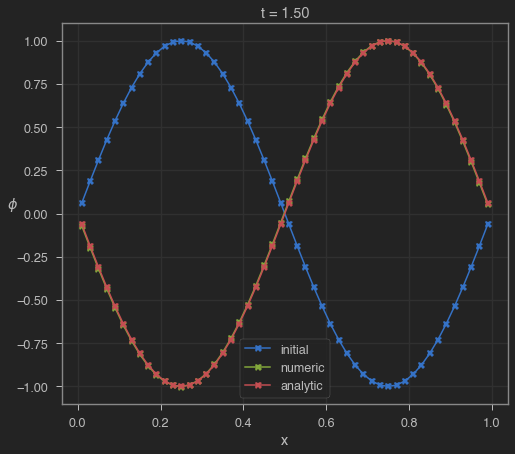

In [60]:
# parmámetros
f, c = geom(50)
u, t, tf = 1, 0, 1.5
dt = 0.2*(f[1] - f[0])/u # CFL

# condiciones iniciales
p0 = smooth(c)
p = p0.copy()
R = np.zeros_like(p)

while t < tf:
	
	# update temporal
	if t + dt > tf:
		dt = tf - t
	t = t + dt
	# print(f't = {t:.2f}, dt = {dt:.2f}')

	F = central(f, u, p)
	F = periodic_central(F, u, p)

	# p = euler(F, f, c, p, dt)
	p, R = ab2(F, f, c, p, dt, R)


plt.plot(c, p0, 'X-', label='initial')
plt.plot(c, p, 'X-', label='numeric')
pa = np.sin(2 * np.pi * (c - u*t ))
plt.plot(c, pa, 'X-', label='analytic')
plt.xlabel('x')
plt.ylabel('$\phi$', rotation=0)
plt.title(f't = {t:.2f}')
plt.grid(True)
plt.legend()
plt.show()

En este caso, usar esquemas de integración de mayor orden ayudan mucho a aliviar la acumulación de errores, obteniendo soluciones muy precisas sin necesidad de aumentar mucho la resolución espacial (lo cual no pasa con métodos upwind).

Vamos a comparar ahora la otra condición inicial. Con una velocidad $u=1$ y ejecutando la simulación durante $1$ unidad temporal, nuestra solución debería coincidir exactamente con la condición inicial. 

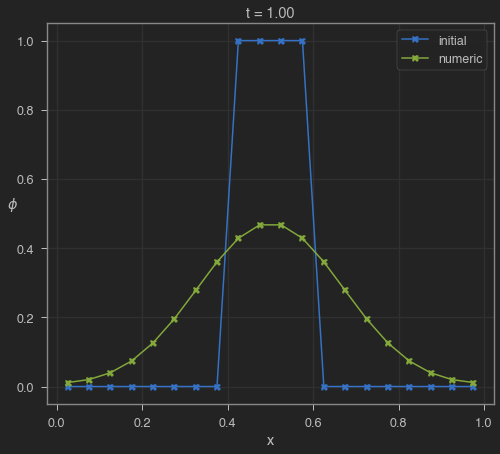

In [61]:
# parmámetros
f, c = geom(20)
u, t, tf = 1, 0, 1
dt = 0.5*(f[1] - f[0])/u # CFL

# condiciones iniciales
p0 = hat(c)
p = p0.copy()

while t < tf:
	
	# update temporal
	if t + dt > tf:
		dt = tf - t
	t = t + dt
	# print(f't = {t:.2f}, dt = {dt:.2f}')

	F = upwind(f, u, p)
	F = periodic_upwind(F, u, p)

	p = euler(F, f, c, p, dt)


plt.plot(c, p0, 'X-', label='initial')
plt.plot(c, p, 'X-', label='numeric')
plt.xlabel('x')
plt.ylabel('$\phi$', rotation=0)
plt.title(f't = {t:.2f}')
plt.grid(True)
plt.legend()
plt.show()

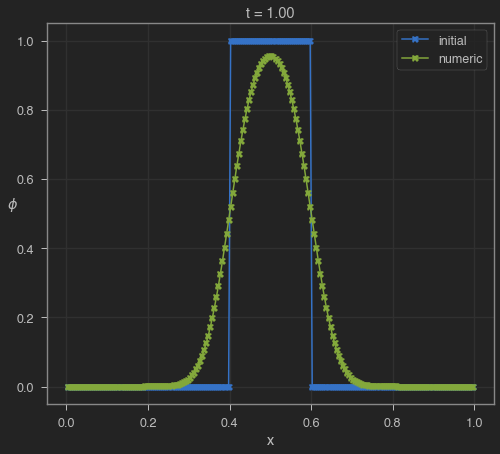

In [64]:
# parmámetros
f, c = geom(200)
u, t, tf = 1, 0, 1
dt = 0.5*(f[1] - f[0])/u # CFL

# condiciones iniciales
p0 = hat(c)
p = p0.copy()
R = np.zeros_like(p)

while t < tf:
	
	# update temporal
	if t + dt > tf:
		dt = tf - t
	t = t + dt
	# print(f't = {t:.2f}, dt = {dt:.2f}')

	F = upwind(f, u, p)
	F = periodic_upwind(F, u, p)

	p = euler(F, f, c, p, dt)
	# p, R = ab2(F, f, c, p, dt, R)


plt.plot(c, p0, 'X-', label='initial')
plt.plot(c, p, 'X-', label='numeric')
plt.xlabel('x')
plt.ylabel('$\phi$', rotation=0)
plt.title(f't = {t:.2f}')
plt.grid(True)
plt.legend()
plt.show()

Usando el esquema upwind no vemos sorpresas y podemos sacar las mismas conclusiones (difusión numérica que se minimiza con mejor malla).

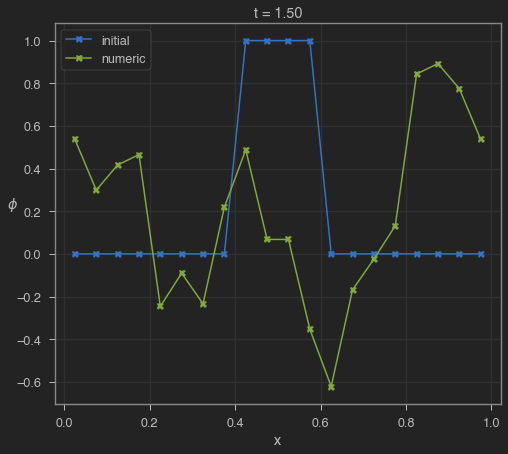

In [65]:
# parmámetros
f, c = geom(20)
u, t, tf = 1, 0, 1.5
dt = 0.2*(f[1] - f[0])/u # CFL

# condiciones iniciales
p0 = hat(c)
p = p0.copy()
R = np.zeros_like(p)

while t < tf:
	
	# update temporal
	if t + dt > tf:
		dt = tf - t
	t = t + dt
	# print(f't = {t:.2f}, dt = {dt:.2f}')

	F = central(f, u, p)
	F = periodic_central(F, u, p)

	# p = euler(F, f, c, p, dt)
	p, R = ab2(F, f, c, p, dt, R)


plt.plot(c, p0, 'X-', label='initial')
plt.plot(c, p, 'X-', label='numeric')
plt.xlabel('x')
plt.ylabel('$\phi$', rotation=0)
plt.title(f't = {t:.2f}')
plt.grid(True)
plt.legend()
plt.show()

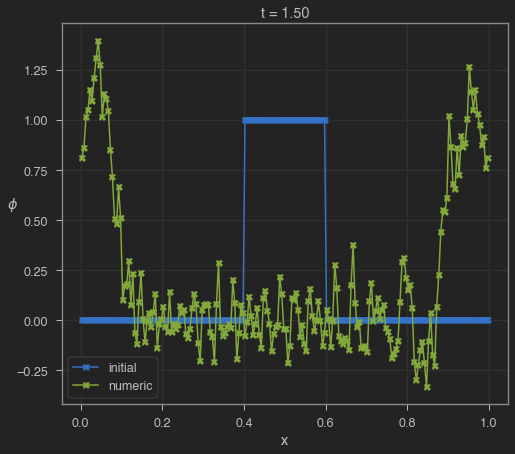

In [66]:
# parmámetros
f, c = geom(200)
u, t, tf = 1, 0, 1.5
dt = 0.2*(f[1] - f[0])/u # CFL

# condiciones iniciales
p0 = hat(c)
p = p0.copy()
R = np.zeros_like(p)

while t < tf:
	
	# update temporal
	if t + dt > tf:
		dt = tf - t
	t = t + dt
	# print(f't = {t:.2f}, dt = {dt:.2f}')

	F = central(f, u, p)
	F = periodic_central(F, u, p)

	#p = euler(F, f, c, p, dt)
	p, R = ab2(F, f, c, p, dt, R)


plt.plot(c, p0, 'X-', label='initial')
plt.plot(c, p, 'X-', label='numeric')
plt.xlabel('x')
plt.ylabel('$\phi$', rotation=0)
plt.title(f't = {t:.2f}')
plt.grid(True)
plt.legend()
plt.show()

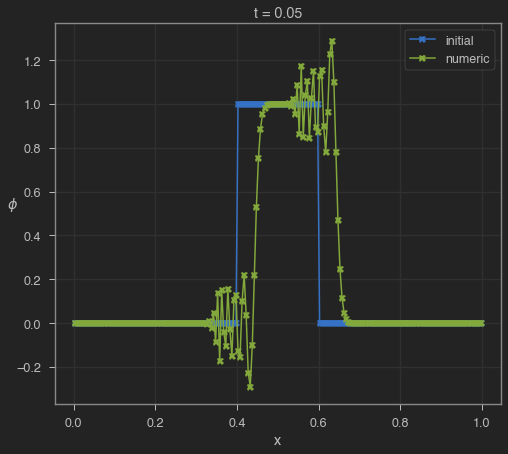

In [67]:
# parmámetros
f, c = geom(200)
u, t, tf = 1, 0, 0.05
dt = 0.2*(f[1] - f[0])/u # CFL

# condiciones iniciales
p0 = hat(c)
p = p0.copy()
R = np.zeros_like(p) 

while t < tf:
	
	# update temporal
	if t + dt > tf:
		dt = tf - t
	t = t + dt
	# print(f't = {t:.2f}, dt = {dt:.2f}')

	F = central(f, u, p)
	F = periodic_central(F, u, p)

	#p = euler(F, f, c, p, dt)
	p, R = ab2(F, f, c, p, dt, R)


plt.plot(c, p0, 'X-', label='initial')
plt.plot(c, p, 'X-', label='numeric')
plt.xlabel('x')
plt.ylabel('$\phi$', rotation=0)
plt.title(f't = {t:.2f}')
plt.grid(True)
plt.legend()
plt.show()

En este caso da igual lo que intentemos, la simulación va a explotar desde el principio. Esto se debe a que los esquemas centrados no sirven para representar soluciones con discontinuidades. Esto es importante ya que cuando trabajemos con fluidos compresibles nos encontraremos ondas de choque, y no podremos usar este tipo de esquemas (al menos no tal cual los hemos visto aquí).

## Resumen

En este post hemos visto los conceptos básicos más importantes que tenemos que tener en cuenta a la hora de llevar acabo nuestras simulaciones. Primero, la discretización del dominio afectará a nuestra solución. Queremos una malla lo suficientemente fina como para capturar las características de nuestro fluido, pero sin pasarnos para evitar un gran coste computacional. Una vez discretizado el dominio, deberemos definir las condiciones iniciales y de contorno, necesarias para resolver cualquier ecuación diferencial. Una vez arranca la simulación, calcularemos los flujos de las variables conservativas en las caras de cada celda. Para ello usaremos esquemas numéricos, de los que hemos visto los de tipo upwind y centrado. Los esquemas de tipo upwind sufren de difusión numérica, pero son muy estables incluso en presencia de discontinuidades. Los esquemas de tipo centrado sufren de acumulación de errores y desfase, pero usando un esquema de integración de alto orden podemos reducir este problema y obtener muy buenas soluciones con mallas menos finas en el caso de soluciones suaves. Si el fluido tiene discontinuidades, los esquemas centrados divergen siempre. Una vez calculados los flujos, haremos el sumatorio de éstos en cada celda y procederemos al *update* temporal usando esquemas de integración como Euler (bajo orden) o Adam Bashforth o Runge Kutta (alto orden).
Como norma general, usaremos esquemas espaciales centrados esquemas de integración temporal de alto orden, ya que éstos nos dan los mejores resultados. En el caso de tener discontinuidades en el flujo, tendremos que hacer algún invento para evitar su explosión, de lo cual hablaremos en futuros posts.